本笔记本说明了我们如何探索和准备用于模型构建的数据。笔记本的结构如下：
 - 数据集介绍
 - 数据概要
 - 特征工程
 - 缺失值分析
 - 异常值分析
 - 相关性分析
 - 数据分布可视化
 - 计数与（月份、季节、小时、工作日、用户类型）的关系可视化
 - 使用随机森林填充风速中的0值
 - 线性回归模型
 - 正则化模型
 - 集成模型

# 1 赛题分析

# 2 数据探索

## 理解数据背景与目标

#### **概述**

共享单车系统是一种租赁自行车的方式，通过城市各处的自动化站点网络，实现会员注册、租赁和还车的自动化过程。使用这些系统，人们可以在一个地点租车，并在需要时将其归还到不同的地点。目前，全球有超过500个共享单车项目。
http://archive.ics.uci.edu/dataset/275/bike+sharing+dataset


https://www.selectdataset.com/data_all_allset/7634a227fafb8431d343eaf30a49e802

#### **数据字段**

* datetime - 小时日期 + 时间戳
* season - 1 = 春季, 2 = 夏季, 3 = 秋季, 4 = 冬季
* holiday - 是否为假日
* workingday - 是否为工作日（非周末或假日）
* weather - 天气情况：
    * 1: 晴天、少云、局部多云
    * 2: 薄雾 + 多云、薄雾 + 碎云、薄雾 + 少云、薄雾
    * 3: 小雪、小雨 + 雷暴 + 散云、小雨 + 散云
    * 4: 大雨 + 冰雹 + 雷暴 + 薄雾、雪 + 雾
* temp - 温度（摄氏度）
* atemp - "体感"温度（摄氏度）
* humidity - 相对湿度
* windspeed - 风速
* casual - 非注册用户租赁数量
* registered - 注册用户租赁数量
* count - 租赁总数量（因变量）

In [11]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## 数据初步观察与概览

**加载数据集**

In [36]:
train_data = pd.read_csv("./data/train.csv")

**查看数据集维度**

In [37]:
train_data.shape

(10886, 12)

**查看数据集前几行**

In [23]:
train_data.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


**查看各个特征的数据类型**

In [24]:
# 使用info()查看信息
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
# 将数值型数据转为文本，方便可视化分析
train_data["season"] = train_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train_data["weather"] = train_data.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

## 时间特征和分类特征处理

In [51]:
train_data = pd.read_csv("./data/train.csv")

In [52]:
## 1 时间特征处理
def process_time_features(data):
    """处理时间特征"""
    data["date"] = data.datetime.apply(lambda x : x.split()[0])
    data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
    data["weekday"] = data.date.apply(lambda x : datetime.strptime(x,"%Y-%m-%d").weekday())
    data["month"] = data.date.apply(lambda x : datetime.strptime(x,"%Y-%m-%d").month)
    data["year"] = data.date.apply(lambda x : datetime.strptime(x,"%Y-%m-%d").year)
    return data
train_data=process_time_features(train_data)
## 删除不必要的列
train_data  = train_data.drop(["datetime"],axis=1)

In [53]:
## 强制转换为类别类型
def convert_to_category(data, category_columns=None):
    """
    将指定列转换为分类(category)类型
    
    参数:
    - data: DataFrame, 输入数据
    - category_columns: list, 需要转换的列名列表
    
    返回:
    - DataFrame: 转换后的数据框
    """
    if category_columns is None:
        print("category_columns is none")
        return
        
    df = data.copy()
    for col in category_columns:
        if col in df.columns:
            df[col] = df[col].astype("category")
        else:
            print(f"警告: 列 {col} 不存在于数据中")
        
    return df

# 调用函数转换数据类型
train_data = convert_to_category(train_data,
                                 category_columns=["season","holiday","workingday","weather","weekday","month","year","hour"])

对于时间特征：
1. 周期性特征(hour,month,weekday)->倾向转分类
2. 顺序性特征(year,day)->倾向保持数值

In [ ]:
## 1.2 分类特征编码-'label' 或 'onehot'
def process_mixed_categorical_features(data, ordinal_features=None, nominal_features=None):
    """
    混合编码策略处理分类特征
    
    参数:
    - data: DataFrame, 输入数据
    - ordinal_features: list, 需要使用label编码的有序特征列表
    - nominal_features: list, 需要使用one-hot编码的无序特征列表
    
    返回:
    - DataFrame: 编码后的数据框
    """
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    
    def get_encoding_type(col_name, n_unique, n_samples):
        """确定特征的编码方式"""
        # 1. 时间相关特征
        if col_name in ['hour', 'month', 'year']:
            return 'label'  # 时间特征通常有序
            
        # 2. 二分类特征
        if n_unique == 2:
            return 'onehot'  # 二分类特征用one-hot不会增加维度
            
        # 3. 一般规则
        if n_unique > 10 or (n_unique/n_samples) > 0.05:
            return 'label'
        else:
            return 'onehot'
    
    # 复制输入数据
    df = data.copy()
    
    # 如果未指定任何特征,则根据特征的基数自动选择编码方式
    if ordinal_features is None and nominal_features is None:
        # 获取所有分类特征
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        
        ordinal_features = []
        nominal_features = []
        
        # 根据特征的基数自动选择编码方式
        for col in categorical_columns:
            n_unique = df[col].nunique()
            n_samples = len(df)
            
            # 使用get_encoding_type确定编码方式
            encoding_type = get_encoding_type(col, n_unique, n_samples)
            
            if encoding_type == 'label':
                ordinal_features.append(col)
                print(f"特征 {col} 使用Label编码: {n_unique}个唯一值, 占比{n_unique/n_samples:.2%}")
            else:
                nominal_features.append(col)
                print(f"特征 {col} 使用One-Hot编码: {n_unique}个唯一值, 占比{n_unique/n_samples:.2%}")
    
    # 1. 处理有序特征(Label Encoding)
    if ordinal_features:
        le = LabelEncoder()
        for col in ordinal_features:
            if col in df.columns:
                df[col] = le.fit_transform(df[col].astype(str))
            else:
                print(f"警告: 列 {col} 不存在于数据中")
    
    # 2. 处理无序特征(One-Hot Encoding)
    if nominal_features:
        df = pd.get_dummies(df, 
                          columns=nominal_features,
                          prefix=nominal_features)
    
    return df

## 统计量分析- 单变量分析
> 考察单个变量的均值、中位数、众数、分位数、方差、变异系数



In [25]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


**数值型特征：**
* 绘制直方图或核密度估计图，观察数据分布。
* 绘制箱线图，识别异常值。
* 小提琴图
    


### 直方图和Q-Q图


从下图可以看出，"count"变量向右偏斜。由于大多数机器学习技术要求因变量呈正态分布，因此最好是正态分布。一个可能的解决方案是在删除异常数据点后对"count"变量进行对数转换。转换后的数据看起来好多了，但仍然不是完全理想的正态分布。


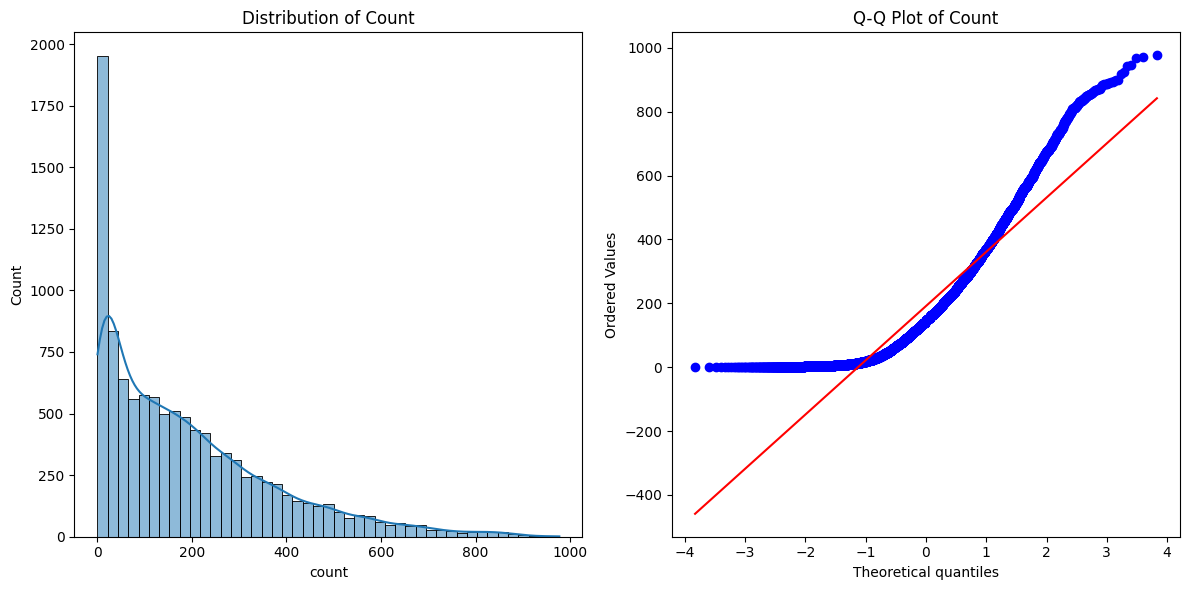

In [26]:
# 创建子图
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(12, 6)

# 原始数据的分布图
sns.histplot(data=train_data, x="count", kde=True, ax=ax1)
ax1.set_title("Distribution of Count")

# 原始数据的Q-Q图
stats.probplot(train_data["count"], dist='norm', fit=True, plot=ax2)
ax2.set_title("Q-Q Plot of Count")

# 调整布局
plt.tight_layout()

从这两张图可以得到以下重要信息：
1. 从分布图(左图)可以看出：
- 数据分布严重右偏（right-skewed）
- 大部分租赁数量集中在较低值区域（0-200左右）
- 分布呈现长尾特征，有少量高值样本
- 不符合正态分布的形状（正态分布应该是钟形的）
2. 从Q-Q图(右图)可以看出：
- 数据点与红色参考线（表示理想的正态分布）有明显偏离
- 在两端的偏离特别明显，说明分布的尾部与正态分布差异较大
- 曲线呈现S形，进一步确认了数据的偏态性
这些发现的实际意义：
1. 建模考虑：
- 可能需要对数据进行转换（如对数转换）使其更接近正态分布
- 需要考虑使用能处理非正态分布的模型
- 在评估模型性能时需要考虑数据的这种偏态特性
2. 业务理解：
- 大多数时候的租赁需求相对较低
- 存在一些高峰期的大量租赁情况
- 这种分布符合共享单车使用的实际情况（日常使用vs特殊事件）
3. 数据处理建议：
- 考虑对数转换（log transformation）
- 可能需要处理异常值
在建模时可能需要分段处理（如分别建模常规需求和高峰需求）

### 箱型图

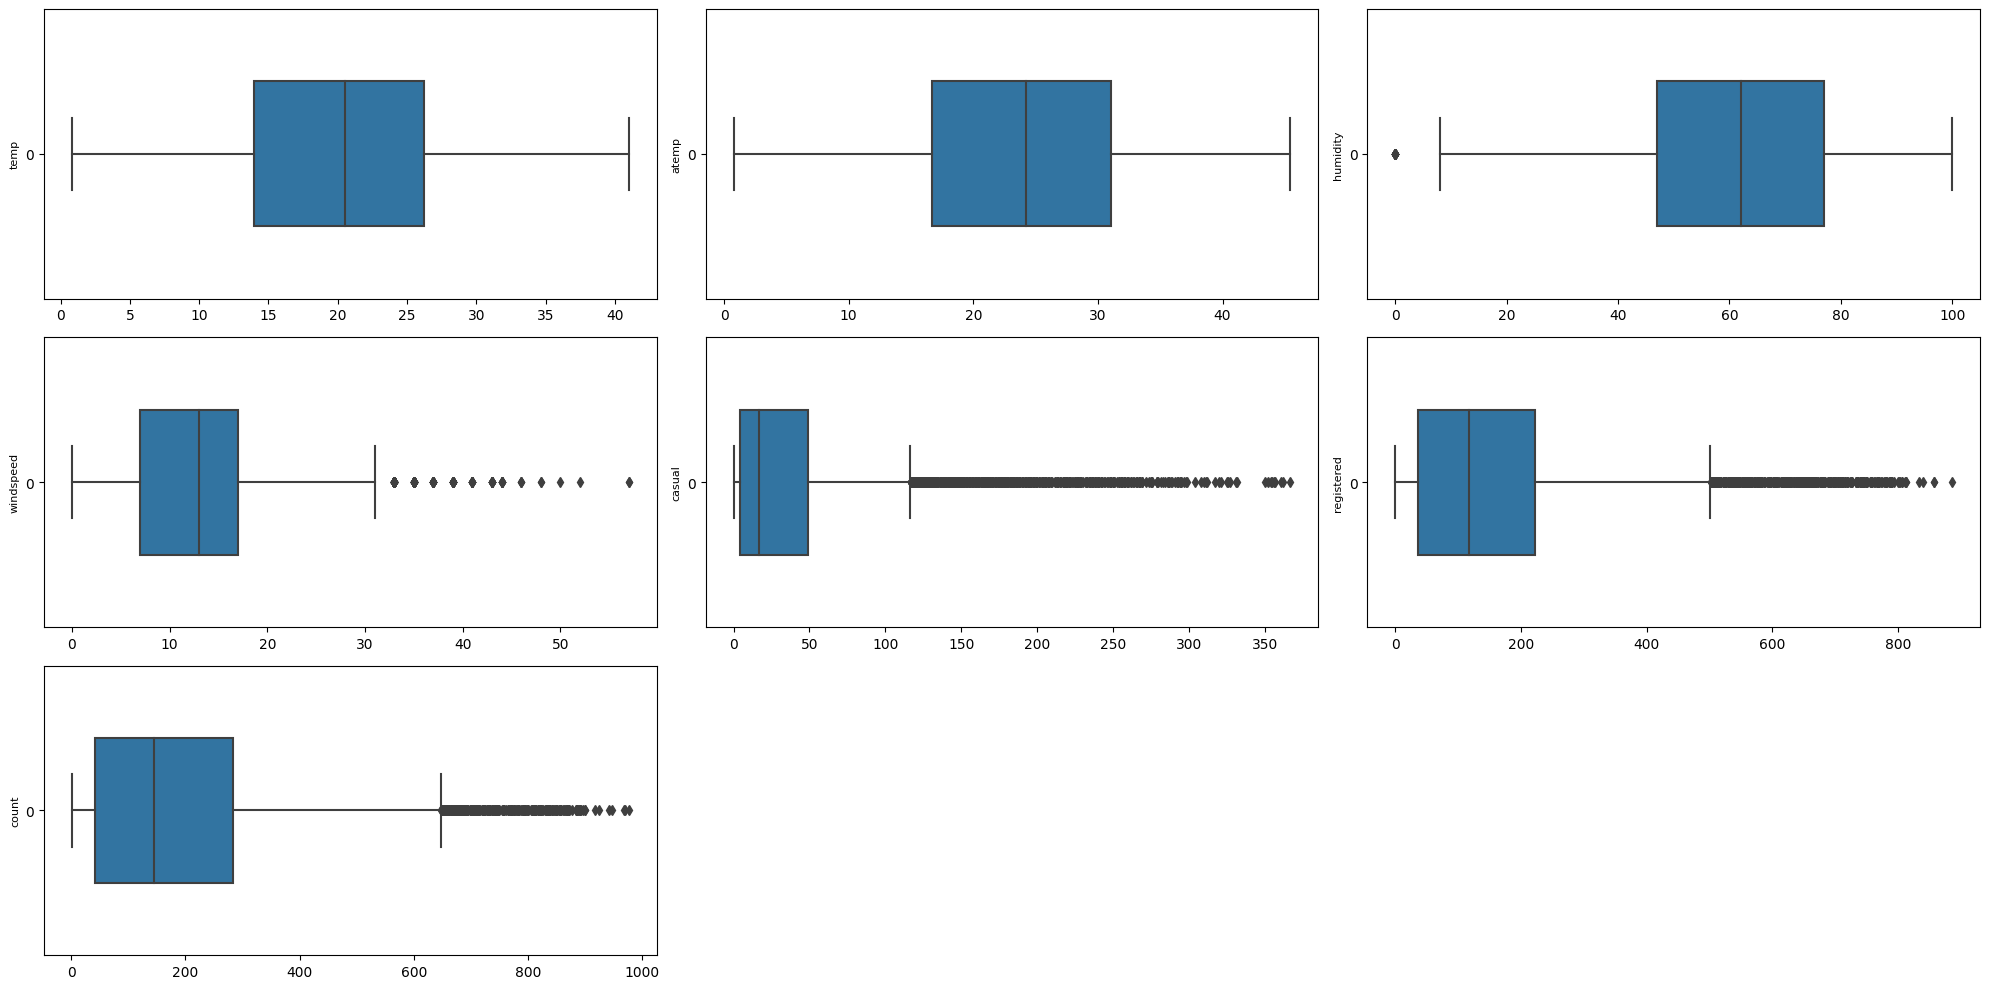

In [27]:
def plot_boxplots(data, columns_to_plot, n_cols=3, figsize=(20,10)):
    """
    绘制指定特征的箱型图
    
    参数:
    - data: DataFrame, 输入数据
    - columns_to_plot: list, 需要绘制箱型图的列名列表
    - n_cols: int, 子图列数,默认为3
    - figsize: tuple, 图形大小,默认为(20,40)
    """
    n_features = len(columns_to_plot)
    n_rows = (n_features - 1) // n_cols + 1  # 计算所需行数
    
    fig = plt.figure(figsize=figsize)
    for i, col in enumerate(columns_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data[col], orient="h", width=0.5)
        plt.ylabel(col, fontsize=8)
    plt.tight_layout()
    plt.show()

# 调用函数绘制箱型图
columns_to_plot = ['temp', 'atemp', 
                   'humidity', 'windspeed', 'casual', 'registered', 'count']
plot_boxplots(train_data, columns_to_plot)

初看之下，"count"变量包含许多异常数据点，这使得分布向右偏斜（因为有更多的数据点超出了外四分位限）。但除此之外，从下面的简单箱线图中还可以得出以下结论：

 - 春季的租赁数量相对较低。箱线图中位数值的下降证实了这一点。
 - "每日小时数"的箱线图非常有趣。在上午7-8点和下午5-6点，中位数值相对较高。这可以归因于该时段的常规上学和上班用户。
 - 大多数异常点主要来自"工作日"而不是"非工作日"。从图4中可以清楚地看到这一点。

ValueError: Could not interpret input 'hour'

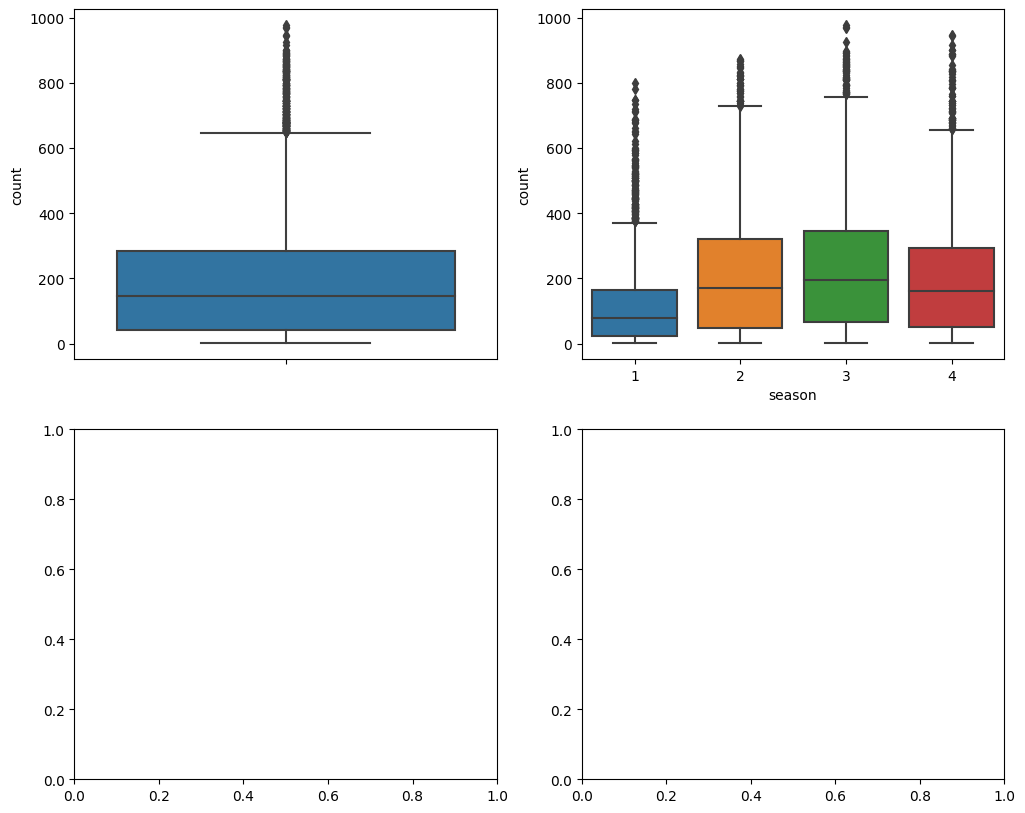

In [28]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train_data,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train_data,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

**类别型特征：**
 * 绘制柱状图，观察各类别的频次和占比。



# ==============================================


# 3 特征工程

### 缺失值分析

一旦我们掌握了数据和列的情况，下一步通常是找出数据中是否存在任何缺失值。幸运的是，我们的数据集中没有任何缺失值。我通常喜欢使用"missingno"来可视化数据集中的缺失值。

这是一个非常方便的库，可以快速可视化变量的缺失值。正如我之前提到的，这次我们很幸运，因为数据集中没有缺失值。


<AxesSubplot:>

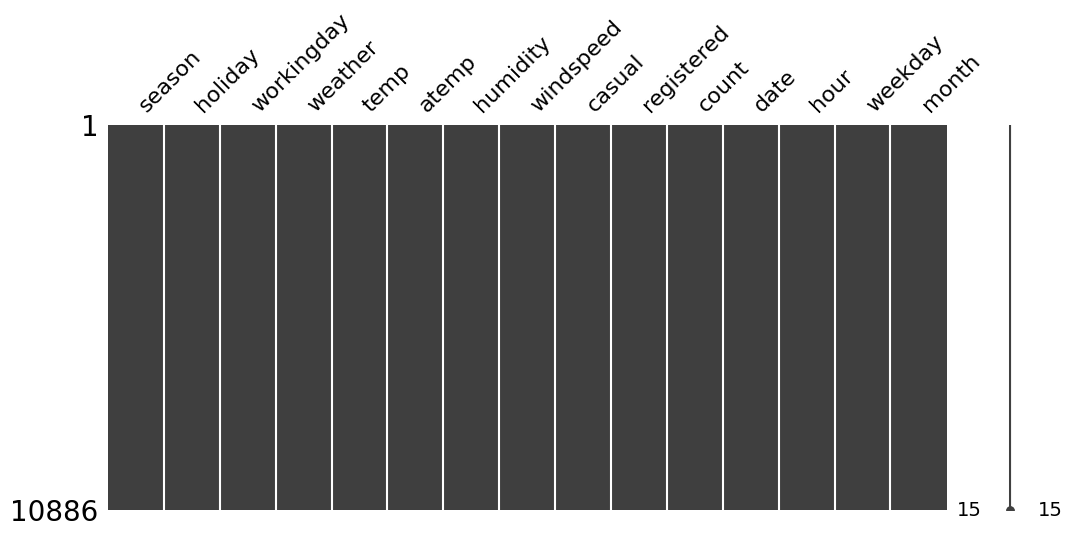

In [35]:
msno.matrix(train_data,figsize=(12,5))

# ==============================================

## 特征工程

从上述结果可以看出，"season"、"holiday"、"workingday"和"weather"列应该是"分类"数据类型。但当前这些列的数据类型是"int"。让我们通过以下方式转换数据集，以便开始我们的探索性数据分析：

 - 从"datetime"列创建新的"date"、"hour"、"weekDay"、"month"列
 - 将"season"、"holiday"、"workingday"和"weather"的数据类型强制转换为category
 - 删除datetime列，因为我们已经从中提取了有用的特征


## 箱型图（异常值分析）

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

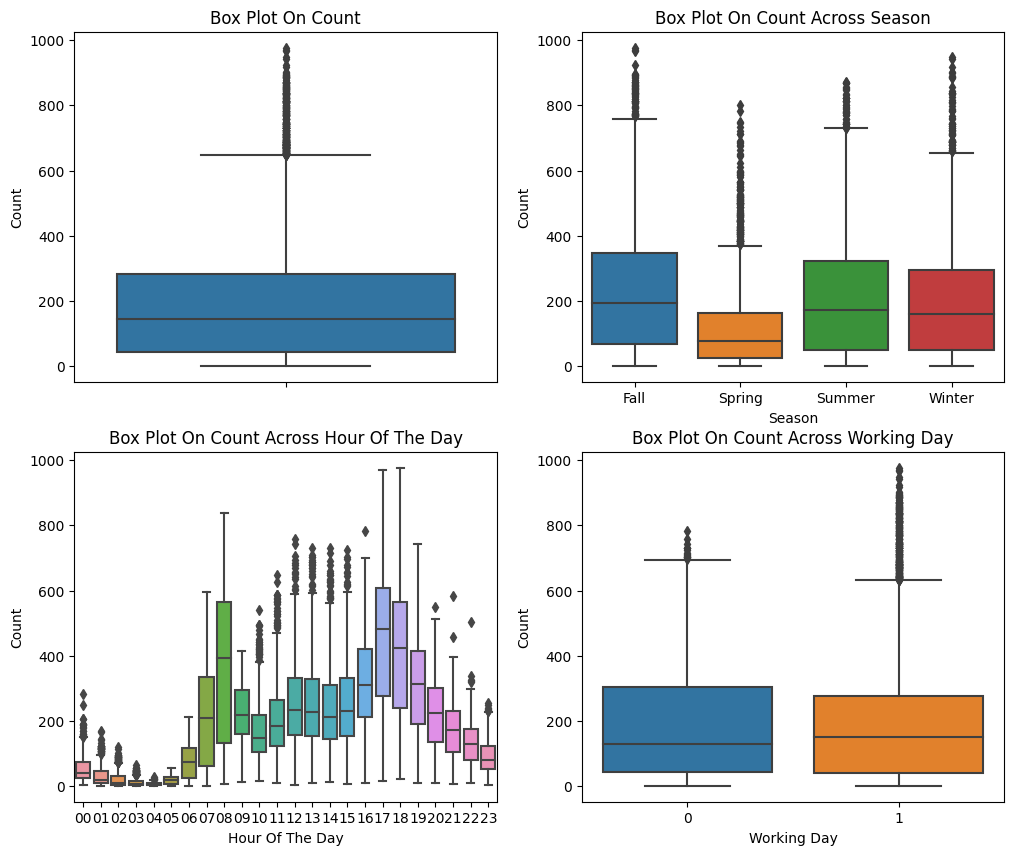

In [34]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train_data,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train_data,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **移除计数列中的异常值**

In [13]:
# 基于模型残差的异常值检测
train_dataWithoutOutliers = train_data[np.abs(train_data["count"]-train_data["count"].mean())<=(3*train_data["count"].std())] 

In [14]:
print ("Shape Of The Before Ouliers: ",train_data.shape)
print ("Shape Of The After Ouliers: ",train_dataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


In [15]:
# 基于模型预测的异常值检测
def find_outliers(model, X, y, sigma=3):
    """
    该函数用于检测数据集中的异常值。
    
    参数:
    - model: 用于预测的模型对象
    - X: 特征数据
    - y: 目标变量
    - sigma: 标准差倍数阈值,默认为3,用于判定异常值
    
    工作流程:
    1. 使用模型对数据进行预测
    2. 计算残差(真实值与预测值的差)
    3. 基于残差的z-score识别异常值
    4. 可视化分析结果
    
    返回:
    - outliers: 异常值的索引
    """

    # 使用模型预测y值
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # 如果预测失败,先拟合模型再预测
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # 计算残差统计量
    resid = y - y_pred     # 计算残差
    mean_resid = resid.mean()  # 残差均值 
    std_resid = resid.std()    # 残差标准差

    # 计算z统计量,将|z|>sigma的点标记为异常值
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # 打印模型性能指标
    print('R2=',model.score(X,y))          # R方值
    print('rmse=',rmse(y, y_pred))         # 均方根误差
    print("mse=",mean_squared_error(y,y_pred))  # 均方误差
    print('---------------------------------------')

    # 打印残差统计信息
    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    # 打印异常值信息
    print(len(outliers),'outliers:')
    print(outliers.tolist())

    # 绘制三个子图进行可视化分析
    plt.figure(figsize=(15,5))
    
    # 子图1:真实值vs预测值的散点图
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    # 子图2:真实值vs残差的散点图
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    # 子图3:z统计量的直方图
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    # 保存可视化结果
    plt.savefig('outliers.png')
    
    return outliers

In [16]:
"""
def find_outliers_classification(model, X, y, threshold=0.7):
    '''
    用于分类问题的异常值检测函数
    
    参数:
    - model: 分类模型对象
    - X: 特征数据
    - y: 目标变量（类别标签）
    - threshold: 预测概率阈值，低于此值的样本被视为异常值（默认0.7）
    
    返回:
    - outliers: 异常值的索引
    '''
    # 确保y是Series类型
    y = pd.Series(y) if not isinstance(y, pd.Series) else y
    
    try:
        # 获取预测概率
        y_prob = pd.DataFrame(model.predict_proba(X), index=y.index)
    except:
        # 如果模型未训练，先进行训练
        model.fit(X, y)
        y_prob = pd.DataFrame(model.predict_proba(X), index=y.index)
    
    # 获取每个样本属于其真实类别的概率
    probs = pd.Series(index=y.index)
    for idx in y.index:
        true_class = y[idx]
        probs[idx] = y_prob.iloc[idx][true_class]
    
    # 标记低于阈值的样本为异常值
    outliers = probs[probs < threshold].index
    
    # 打印模型性能指标
    print('Accuracy =', model.score(X, y))
    print('Number of outliers detected:', len(outliers))
    print('Percentage of outliers:', f"{(len(outliers)/len(y))*100:.2f}%")
    print('---------------------------------------')
    
    # 可视化
    plt.figure(figsize=(15, 5))
    
    # 子图1：预测概率分布
    plt.subplot(131)
    plt.hist(probs, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--')
    plt.title('Distribution of Prediction Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    
    # 子图2：各类别的异常值分布
    plt.subplot(132)
    outlier_by_class = y[outliers].value_counts()
    plt.bar(outlier_by_class.index, outlier_by_class.values)
    plt.title('Outliers by Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Outliers')
    
    # 子图3：正常值vs异常值的比例
    plt.subplot(133)
    plt.pie([len(y)-len(outliers), len(outliers)], 
            labels=['Normal', 'Outlier'],
            autopct='%1.1f%%')
    plt.title('Normal vs Outlier Samples')
    
    plt.tight_layout()
    plt.savefig('classification_outliers.png')
    
    return outliers

# 使用示例：
'''
from sklearn.ensemble import RandomForestClassifier

# 创建分类模型
clf = RandomForestClassifier(random_state=42)

# 检测异常值
outliers = find_outliers_classification(
    model=clf,
    X=X,  # 特征数据
    y=y,  # 类别标签
    threshold=0.7  # 预测概率阈值
)
'''
"""

'\ndef find_outliers_classification(model, X, y, threshold=0.7):\n    \'\'\'\n    用于分类问题的异常值检测函数\n    \n    参数:\n    - model: 分类模型对象\n    - X: 特征数据\n    - y: 目标变量（类别标签）\n    - threshold: 预测概率阈值，低于此值的样本被视为异常值（默认0.7）\n    \n    返回:\n    - outliers: 异常值的索引\n    \'\'\'\n    # 确保y是Series类型\n    y = pd.Series(y) if not isinstance(y, pd.Series) else y\n    \n    try:\n        # 获取预测概率\n        y_prob = pd.DataFrame(model.predict_proba(X), index=y.index)\n    except:\n        # 如果模型未训练，先进行训练\n        model.fit(X, y)\n        y_prob = pd.DataFrame(model.predict_proba(X), index=y.index)\n    \n    # 获取每个样本属于其真实类别的概率\n    probs = pd.Series(index=y.index)\n    for idx in y.index:\n        true_class = y[idx]\n        probs[idx] = y_prob.iloc[idx][true_class]\n    \n    # 标记低于阈值的样本为异常值\n    outliers = probs[probs < threshold].index\n    \n    # 打印模型性能指标\n    print(\'Accuracy =\', model.score(X, y))\n    print(\'Number of outliers detected:\', len(outliers))\n    print(\'Percentage of outliers:\', f

主要改动和特点：
1. 核心思想改变：
- 回归问题：基于预测值与真实值的残差
- 分类问题：基于模型预测的概率值
2. 异常值判定标准：
- 使用预测概率阈值（threshold）
- 如果样本被分类为其真实类别的概率低于阈值，则视为异常值
3. 可视化改进：
- 预测概率分布图
- 各类别异常值分布图
- 正常值vs异常值的比例饼图
4. 性能指标改变：
- 使用准确率替代R²
- 展示异常值在各类别中的分布
使用建议：
1. 阈值选择：
- threshold值越高，检测到的异常值越多
- 建议根据具体问题调整（0.5-0.9之间）
2. 适用场景：
- 数据质量检查
- 识别标签可能有误的样本
- 发现难以分类的边界案例
3. 注意事项：
- 确保模型有predict_proba方法
- 考虑类别不平衡问题
- 可能需要根据具体问题调整可视化方式

这个方法特别适合：
- 多分类问题
- 需要识别标签可能有误的样本
- 需要找出难以分类的案例
- 数据清洗和质量控制

## 相关性分析

理解因变量如何受到特征（数值型）影响的一种常见方法是找出它们之间的相关矩阵。让我们绘制"count"与["temp","atemp","humidity","windspeed"]之间的相关图。

 - temp和humidity特征与count分别呈正相关和负相关。虽然它们之间的相关性不是很显著，但count变量与"temp"和"humidity"仍有一定的依赖关系。
 - windspeed不会是真正有用的数值特征，这从它与"count"的相关值可以看出。
 - "atemp"变量没有被考虑，因为"atemp"和"temp"之间存在强相关性。在模型构建过程中，必须删除其中一个变量，因为它们会在数据中表现出多重共线性。
 - "Casual"和"Registered"也没有被考虑，因为它们本质上是泄露变量，在模型构建过程中需要删除。

seaborn中的回归图是描述两个特征之间关系的一种有用方式。这里我们考虑"count"与"temp"、"humidity"、"windspeed"的关系。


<AxesSubplot:>

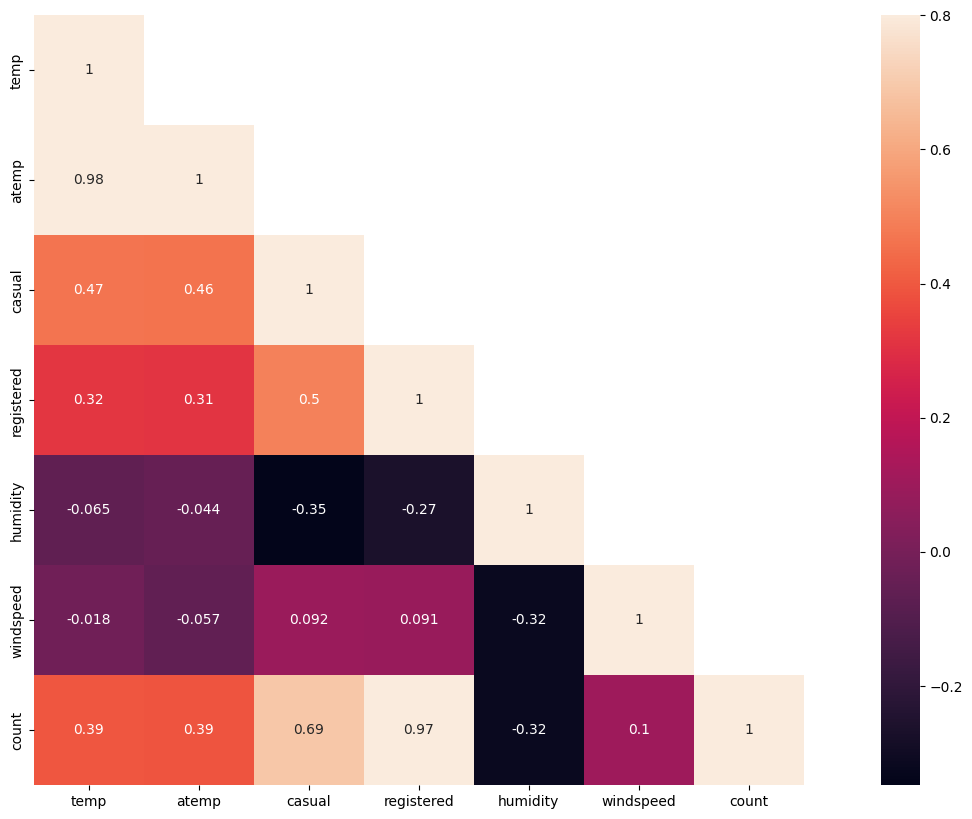

In [17]:
corrMatt = train_data[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

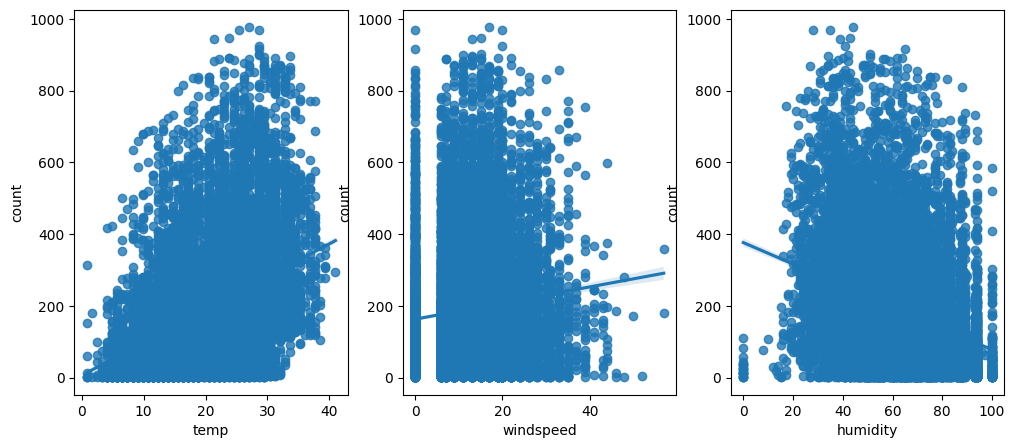

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=train_data,ax=ax1)
sn.regplot(x="windspeed", y="count", data=train_data,ax=ax2)
sn.regplot(x="humidity", y="count", data=train_data,ax=ax3)

## 计数与（月份、季节、小时、工作日、用户类型）的可视化

 - 很明显，人们倾向于在夏季租用自行车，因为那个季节骑自行车的条件真的很好。因此，六月、七月和八月的自行车需求相对较高。
 - 在工作日，更多人倾向于在上午7-8点和下午5-6点租用自行车。如前所述，这可以归因于常规的上学和上班通勤者。
 - 在"周六"和"周日"没有观察到上述模式。更多人倾向于在上午10点到下午4点之间租用自行车。
 - 上午7-8点和下午5-6点的用户高峰完全是由注册用户贡献的。


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

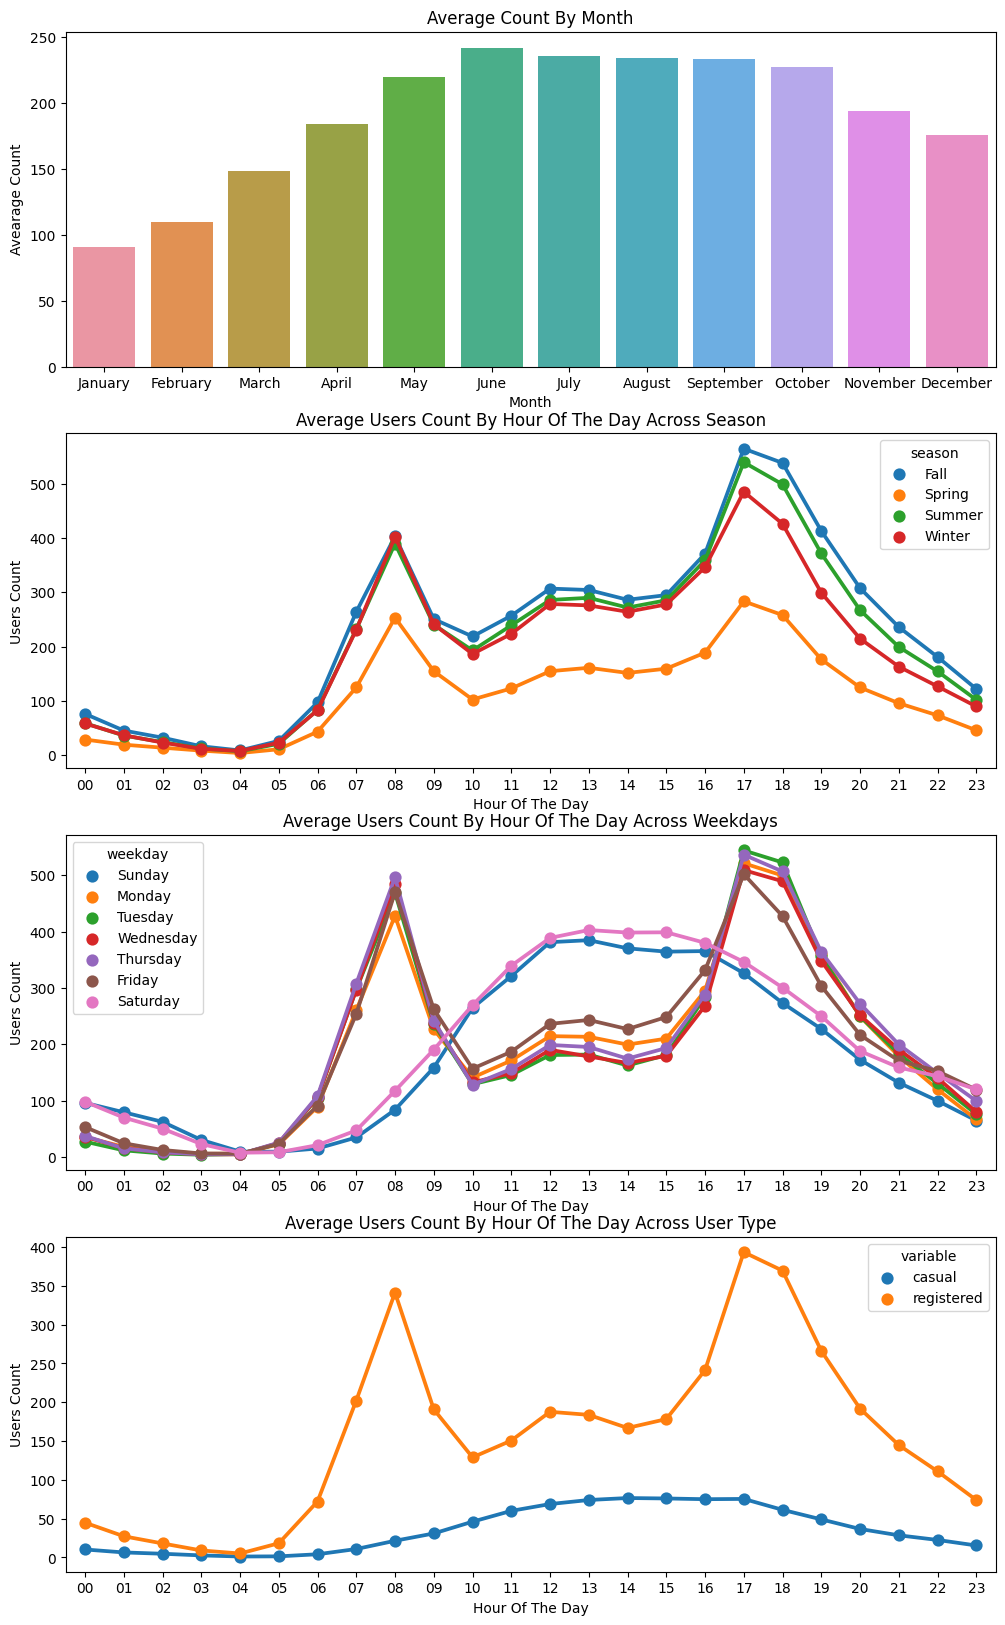

In [20]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train_data.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(train_data.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_data.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(train_data[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

## 使用随机森林填补风速中的0值

**读取训练和测试数据**

In [21]:
train_data = pd.read_csv("./data/train.csv")
submit_data = pd.read_csv("./data/test.csv")

**合并训练集和测试集**

In [22]:
data_all = train_data.append(submit_data)
data_all.reset_index(inplace=True)
data_all.drop('index',inplace=True,axis=1)

**特征工程**

In [23]:
data_all["date"] = data_all.datetime.apply(lambda x : x.split()[0])
data_all["hour"] = data_all.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data_all["year"] = data_all.datetime.apply(lambda x : x.split()[0].split("-")[0])
data_all["weekday"] = data_all.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data_all["month"] = data_all.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

**使用随机森林模型预测风速中的0值**

In [21]:
# 随机森林填充缺失值
from sklearn.ensemble import RandomForestRegressor
def fill_missing_with_rf(data, target_columns, feature_columns, missing_value=0):
    """
    使用随机森林模型填充多个特征中的缺失值
    
    参数:
    data: DataFrame, 包含目标列和特征列的数据框
    target_columns: str or list, 需要填充的目标列名(可以是单个字符串或列表)
    feature_columns: list, 用于预测的特征列名列表
    missing_value: any, 需要填充的值（默认为0）
    
    返回:
    DataFrame: 填充后的数据框
    """
    # 复制输入数据，避免修改原始数据
    df = data.copy()
    
    # 将target_columns转换为列表
    if isinstance(target_columns, str):
        target_columns = [target_columns]
    
    # 对每个目标列进行填充
    for target_column in target_columns:
        print(f"\n开始处理列: {target_column}")
        
        # 将数据分为包含缺失值和不包含缺失值的两部分
        data_missing = df[df[target_column] == missing_value]
        data_not_missing = df[df[target_column] != missing_value]
        
        # 如果没有缺失值，跳过当前列
        if len(data_missing) == 0:
            print(f"列 {target_column} 中没有发现值为{missing_value}的记录，无需填充。")
            continue
        
        # 创建并训练随机森林模型
        rf_model = RandomForestRegressor(random_state=42)
        rf_model.fit(data_not_missing[feature_columns], 
                    data_not_missing[target_column])
        
        # 预测缺失值
        predicted_values = rf_model.predict(data_missing[feature_columns])
        
        # 将预测值填充到缺失值位置
        df.loc[df[target_column] == missing_value, target_column] = predicted_values
        
        print(f"列 {target_column} 已成功填充 {len(data_missing)} 条记录。")
    
    return df

# 使用示例:
# 定义特征列
feature_cols = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

# 方式1: 填充单个列
data_all_filled = fill_missing_with_rf(
    data=data_all,
    target_columns="windspeed",  # 单个列名
    feature_columns=feature_cols,
    missing_value=0
)
"""
# 方式2: 填充多个列
data_filled = fill_missing_with_rf(
    data=data_all,
    target_columns=["windspeed", "humidity"],  # 多个列名
    feature_columns=feature_cols,
    missing_value=0
)
"""


开始处理列: windspeed
列 windspeed 已成功填充 2180 条记录。


'\n# 方式2: 填充多个列\ndata_filled = fill_missing_with_rf(\n    data=data,\n    target_columns=["windspeed", "humidity"],  # 多个列名\n    feature_columns=feature_cols,\n    missing_value=0\n)\n'

**将数据强制转换为分类类型**

In [22]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [23]:
for var in categoricalFeatureNames:
    data_all_filled[var] = data_all_filled[var].astype("category")

**分割训练数据和测试数据**

In [24]:
train_data = data_all_filled[pd.notnull(data_all_filled['count'])].sort_values(by=["datetime"])
submit_data = data_all_filled[~pd.notnull(data_all_filled['count'])].sort_values(by=["datetime"])
datetimecol = submit_data["datetime"]
yLabels = train_data["count"]
yLablesRegistered = train_data["registered"]
yLablesCasual = train_data["casual"]

**去除不必要的变量**

In [25]:
train_data  = train_data.drop(dropFeatures,axis=1)
submit_data  = submit_data.drop(dropFeatures,axis=1)

**RMSLE评分器**

In [26]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# 0模型训练

## 1.1 导包

In [27]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

# 2 获取训练和测试数据
原先将训练集和测试集进行合并处理，现在进行拆分。使用简单交叉验证方法对模型进行验证，划为训练数据为70%，验证数据为30%

In [ ]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

# 3 模型评价函数
将RMSE和MSE作为模型性能的评价指标。

In [ ]:
from sklearn.metrics import make_scorer
# metric for evaluation 自定义
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    return np.sqrt(sum_sq/n)

def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False) # greater_is_better=False 意味着rmse越小越好
mse_scorer = make_scorer(mse, greater_is_better=False)

# 4  处理异常数据

R2= 0.8794138468263233
rmse= 0.34510338853546346
mse= 0.11909634877865903
---------------------------------------
mean of residuals: -2.96425702171071e-16
std of residuals: 0.3451887995969211
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


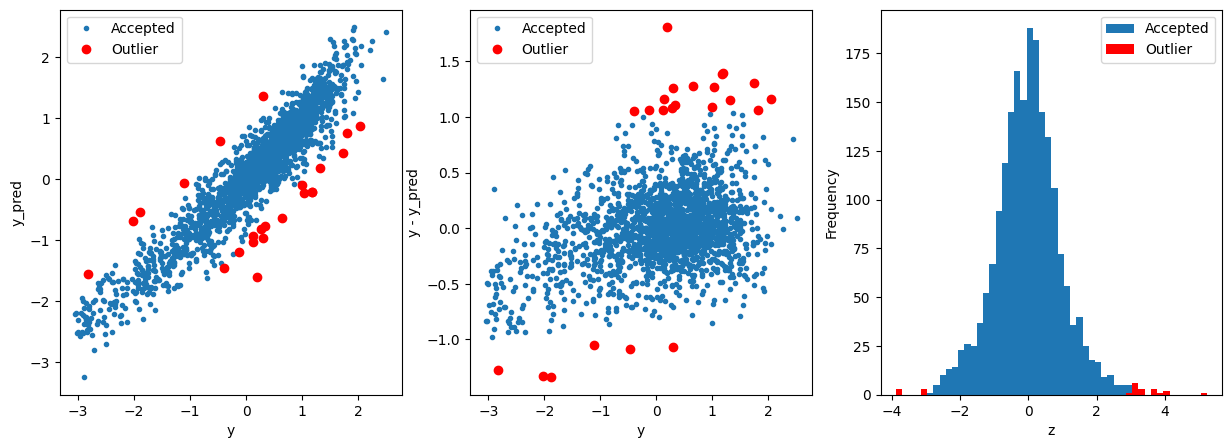

In [ ]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

# 5 网格搜索训练模型

In [ ]:
def get_trainning_data_omitoutliers():
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

使用网格搜索训练模型

In [ ]:
from sklearn.preprocessing import StandardScaler
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified 
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        #poly_trans=PolynomialFeatures(degree=2)
        #X=poly_trans.fit_transform(X)
        #X=MinMaxScaler().fit_transform(X)
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_ # 获取最佳模型的索引
 
        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_) # .cv_results_ 每个参数组合的得分、标准差等信息       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [ ]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

# 6 单一模型训练
## 6.1 岭回归
使用岭回归模型对数据进行预测，采用RMSE,MSE等指标对模型性能进行评价

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Ridge(alpha=0.25)
----------------------
score= 0.8963563380306225
rmse= 0.31899649233050603
mse= 0.1017587621191668
cross_val: mean= 0.10644934256965052 , std= 0.005302313654798051


Text(0, 0.5, 'score')

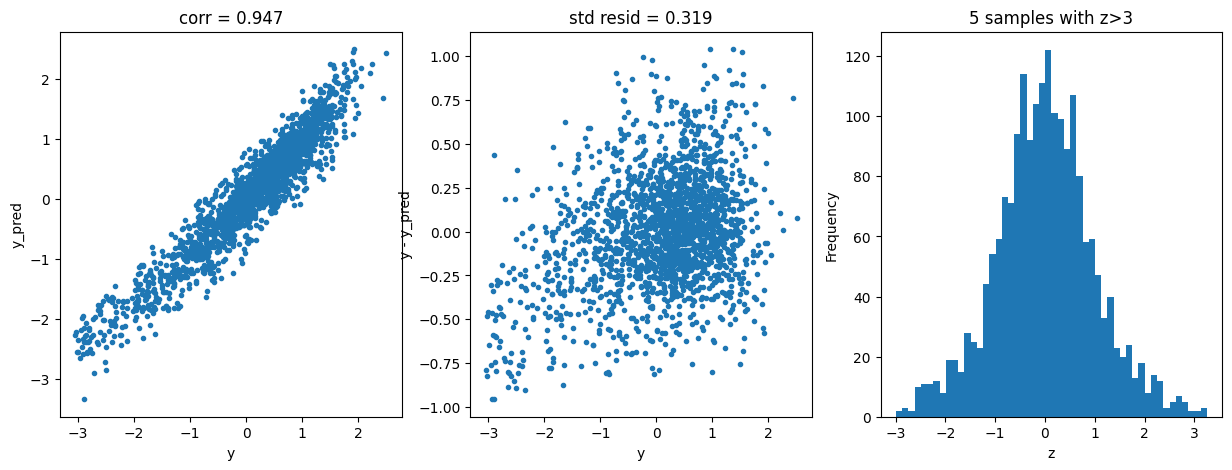

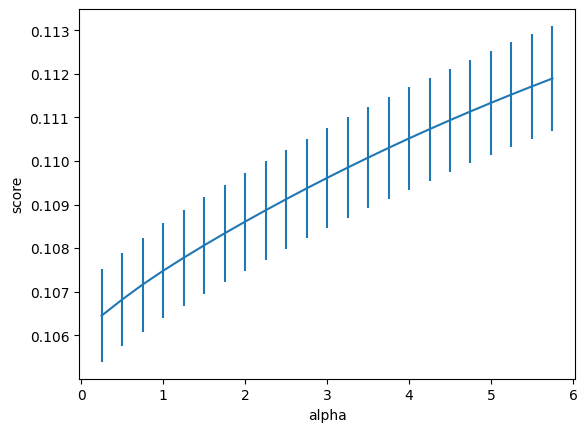

In [ ]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

上面的图形主要反映了模型预测的准确度及拟合情况，后面的模型也将进行类似的可视化分析。这里对图形展示的信息进行介绍，从左至右依次如下：

    (1)真实值（横轴：y)与模型预测值（竖轴：y pred)的散点图，图形上方显示了相关性数值，其越接近1越好。对于岭回归模型，相关性数值为0.947，预测值与真实值比较一致。

    (2)其为在交叉验证训练模型时，真实值（横轴：y)与模型预测值和真实值的残差（竖轴：y-y_pred)的散点图，图形上方显示了方差，其越小说明模型越稳定。可以看到，对于岭回归模型，在真实值y=-3附近的预测值有较大的偏差，同时，方差为0.319，较为稳定。
    
    (3)图是由模型预测值和真实值的残差（横轴：z=(resid-mean resid)/std resid)与落在按z轴划分区间的频率（竖轴：频数）所画的直方图，图形上方显示了预测值与真实值的残差大于三倍标准差的数，其越小越好，越大说明预测中有些样本的偏差很大。对于岭回归模型，预测值与真实值的残差大于三倍标准差的数为5个，模型对偏差大的数据有较好的包容性。
    
    (4)岭回归模型的参数（横轴：alpha)与模型的评价指标MSE(竖轴：score)的误差棒图。
    可以看出，对于岭回归模型，随着alpha的增大，评价指标MSE的数值也越来越大，其模型的方差也逐渐增大。

#### 代码解释
1. 



```python
cv_score.name = model
score_models = score_models.append(cv_score)
````

```python
print(cv_score.name)
print("-------")
print(score_models)
```

```python
# 结果
Ridge
-------
           mean       std
Ridge  0.106211  0.007446
```

------

2. 



```python
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
  ```
代码根据给定的数据点集合在图表上绘制条形图，并添加以标准误差为高度的误差线。


- `errorbar()` 用于绘制带有误差线的条形图。

参数解释:
- `alph_range` 是 x 轴上的数据点集合，它表示自变量的取值范围。
- `abs(grid_results['mean_test_score'])` 是 y 轴上的数据点集合，它表示不同自变量取值下的平均测试分数的绝对值。
- `abs(grid_results['std_test_score'])/np.sqrt(splits*repeats)` 是误差条的高度。`grid_results['std_test_score']` 表示测试分数的标准差，而 `splits` 和 `repeats` 是进行交叉验证时划分数据集的折数和重复次数，通过除以sqrt(splits*repeats) 来将标准差转换为标准误差。


## 6.2 Lasso回归
使用Lasso回归模型对数据进行预测，采用RMSE,MSE等指标对模型性能进行评价

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Lasso(alpha=0.0001)
----------------------
score= 0.8965376022911505
rmse= 0.3187174209135977
mse= 0.10158079439381539
cross_val: mean= 0.1062923603647315 , std= 0.007051871077111589


Text(0, 0.5, 'score')

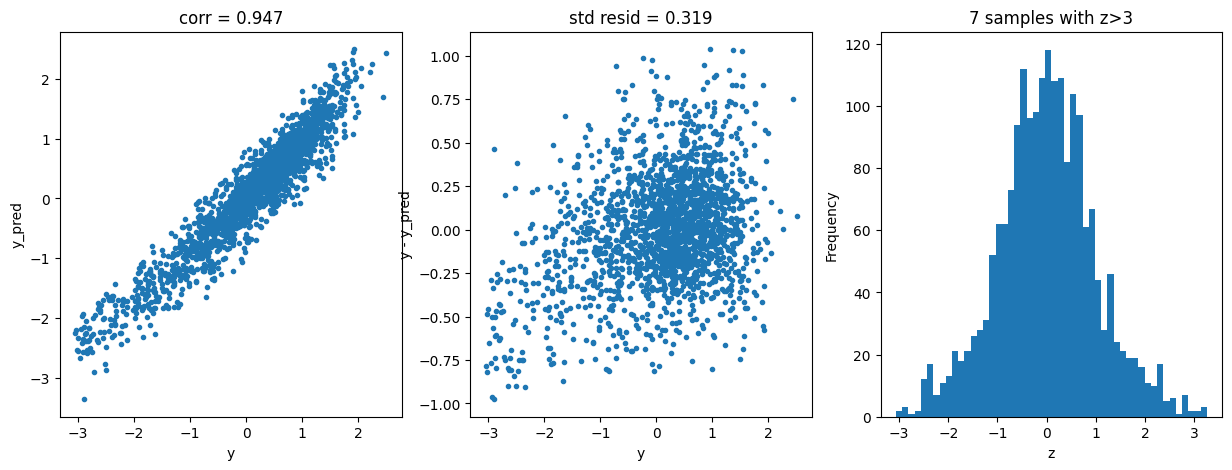

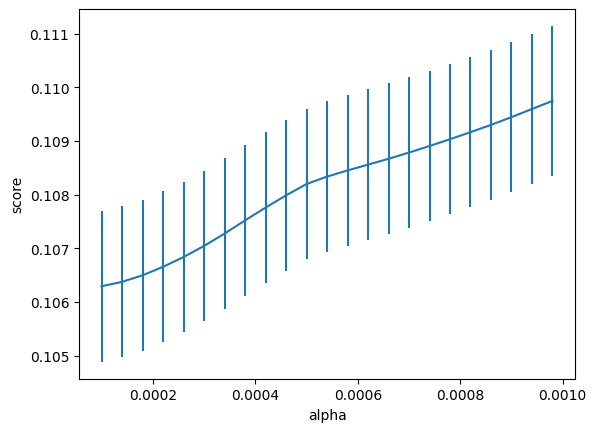

In [ ]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

## 6.3 ElasticNet 回归

Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------
ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=100000)
----------------------
score= 0.8965268226984906
rmse= 0.3187340238271355
mse= 0.10159137794503677
cross_val: mean= 0.10558612445735098 , std= 0.006931804612280223


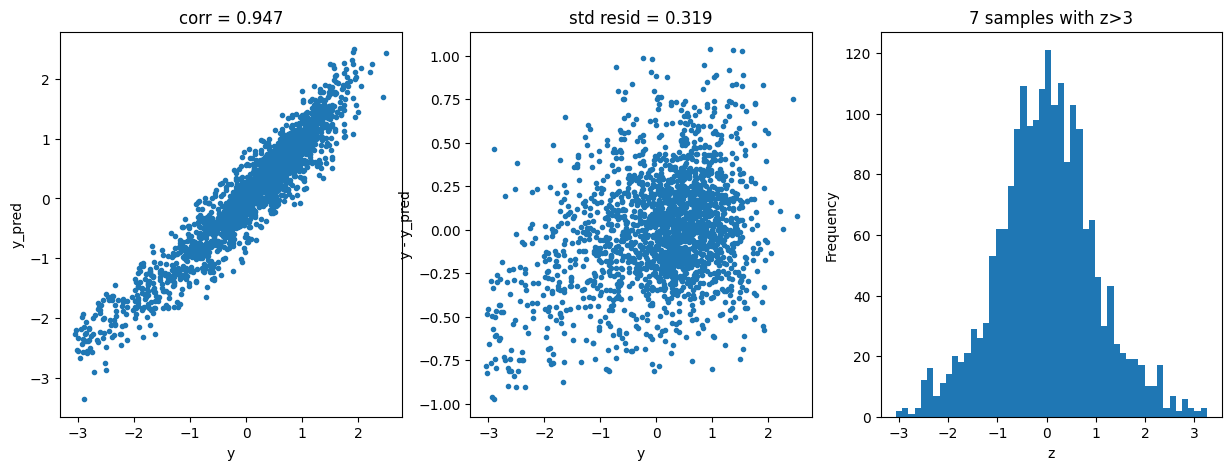

In [ ]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## 6.4 SVR回归

Fitting 25 folds for each of 9 candidates, totalling 225 fits
----------------------
LinearSVR(C=0.4)
----------------------
score= 0.30645151350483657
rmse= 0.8251880824335185
mse= 0.680935371390307
cross_val: mean= 0.9136545268818084 , std= 0.5904526473477509


Text(0, 0.5, 'score')

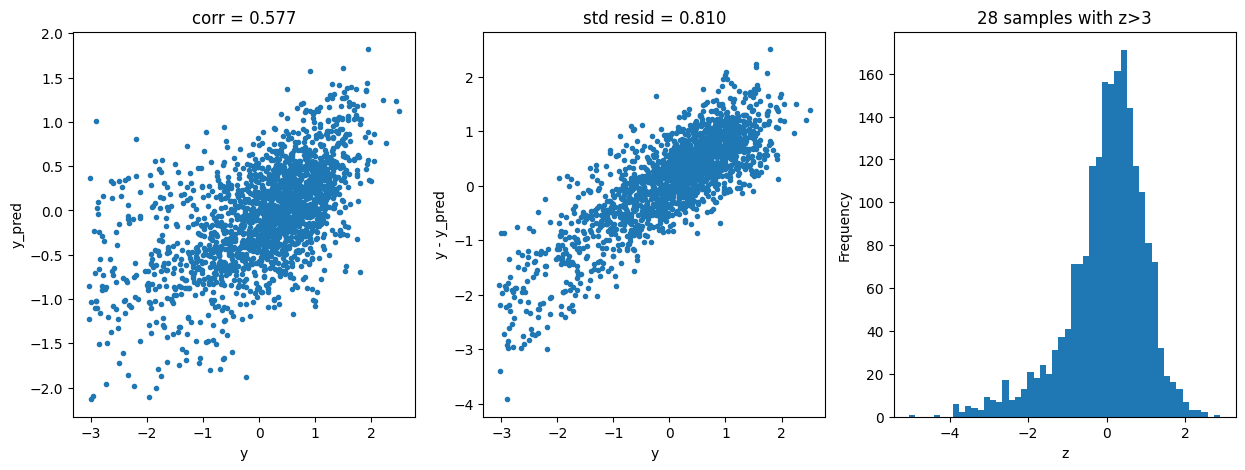

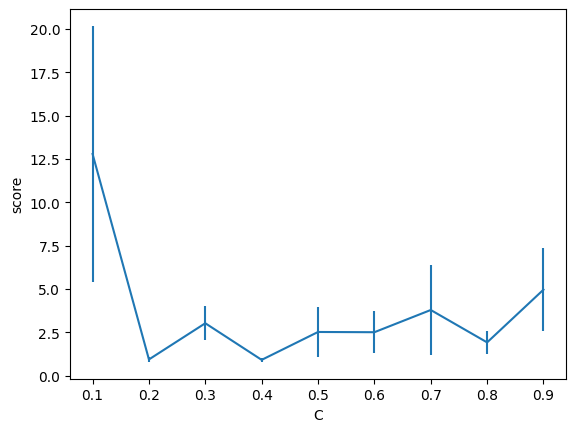

In [ ]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')


## 6.5 K近邻

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------
KNeighborsRegressor(n_neighbors=10)
----------------------
score= 0.7188007679386812
rmse= 0.5254381453364182
mse= 0.27608524457457456
cross_val: mean= 0.35006829225711783 , std= 0.04461643597140863


Text(0, 0.5, 'score')

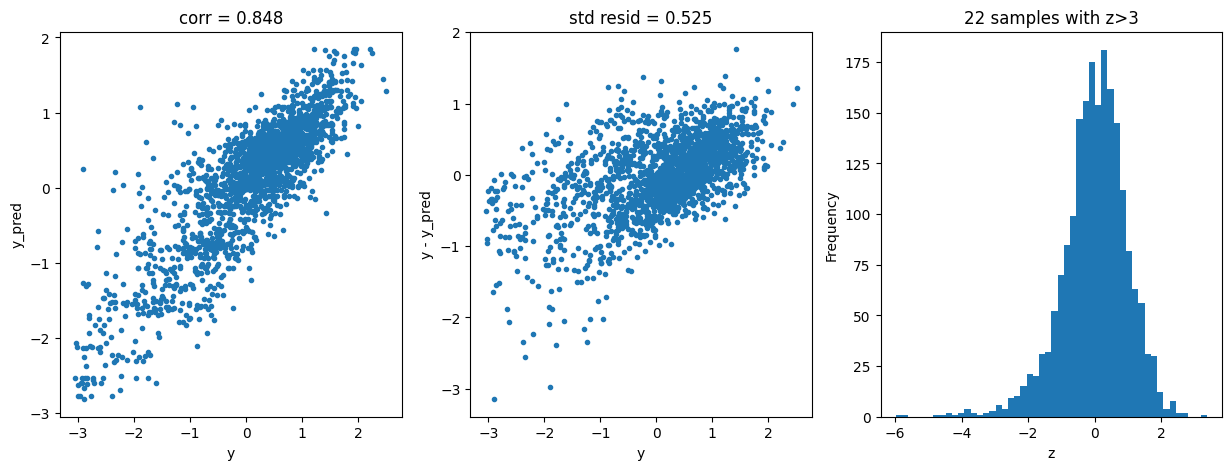

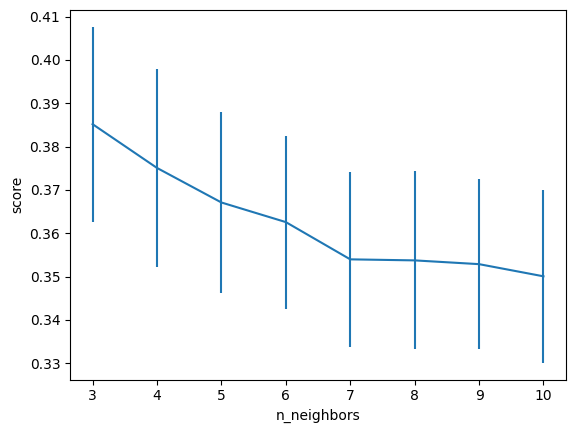

In [ ]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

# 7 模型融合 Boosting方法
把n个比较弱的模型，组合成一个比较强的模型。类似于随机森林。
## 7.1 GBDT 模型
使用 Gradient Boosting模型对数据进行预测，采用RMSE,MSE等指标对模型性能进行评价

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
GradientBoostingRegressor(min_samples_split=6, n_estimators=250)
----------------------
score= 0.9677208586746097
rmse= 0.17802275580033733
mse= 0.03169210158274656
cross_val: mean= 0.09849105444854306 , std= 0.014499755846113458


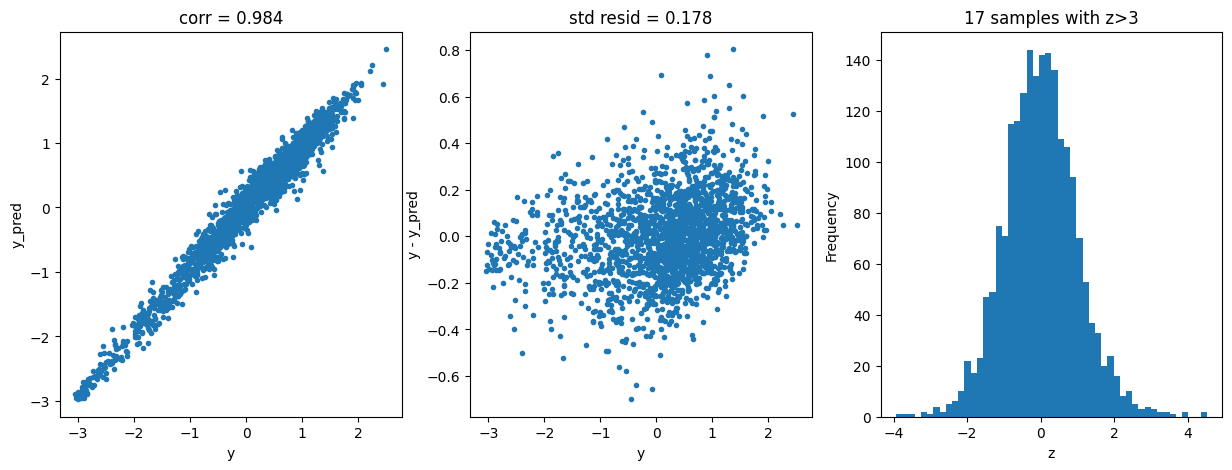

In [ ]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## 7.2 XGBoost模型

Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------------------
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
----------------------
score= 0.9702586237542838
rmse= 0.1708815062712164
mse= 0.029200489185519693
cross_val: mean= 0.10472580078722642 , std= 0.006953064644267524


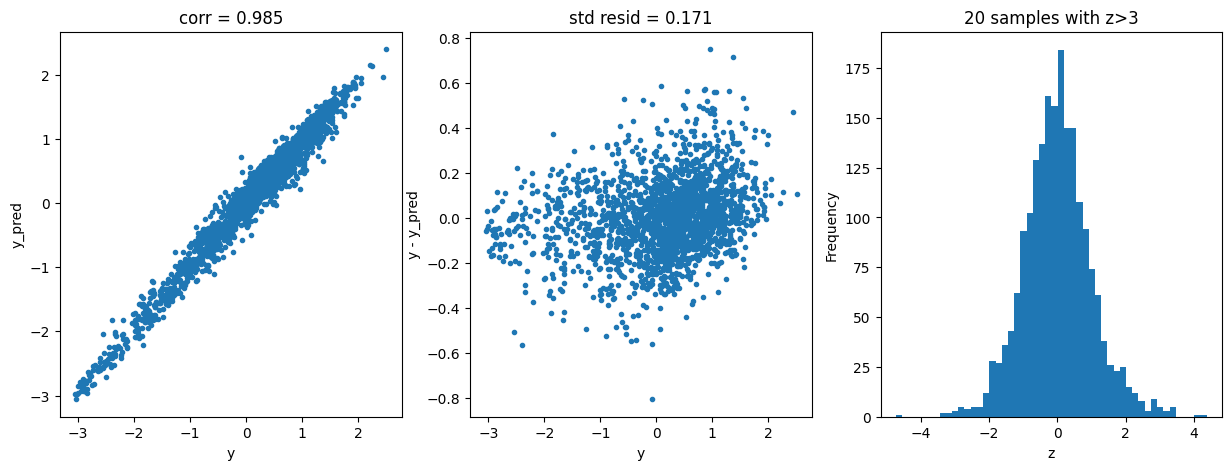

In [ ]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## 7.3 随机森林模型

Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------------------
RandomForestRegressor(max_features=16, n_estimators=150)
----------------------
score= 0.9856162598758819
rmse= 0.11883666269492393
mse= 0.01412215240046713
cross_val: mean= 0.10239417326207083 , std= 0.006602546408163406


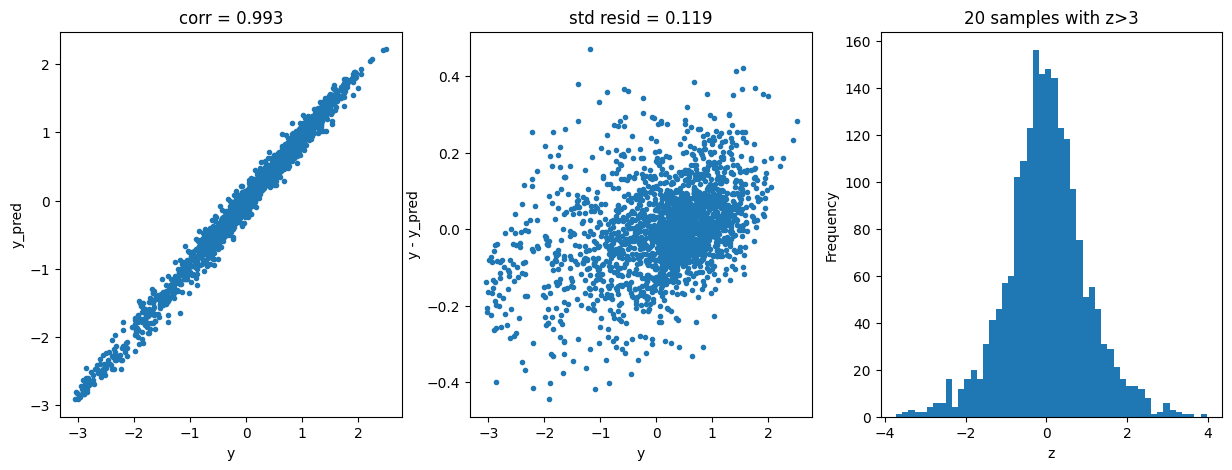

In [ ]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[8,12,16,20,24],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

# 8 多模型预测 Bagging方法
 Bagging 通常对分类任务使用简单投票法，对回归任务使用简单平均法.

In [ ]:
def model_predict(test_data,test_y=[],stack=False):
    #poly_trans=PolynomialFeatures(degree=2)
    #test_data1=poly_trans.fit_transform(test_data)
    #test_data=MinMaxScaler().fit_transform(test_data)
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3) # 模型融合的mean
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [ ]:
model_predict(X_valid,y_valid)

Ridge_mse: 0.137671879096647
Lasso_mse: 0.13786142881850508
ElasticNet_mse: 0.1378268557408619
LinearSVR_mse: 0.1378268557408619
KNeighbors_mse: 0.1378268557408619
GradientBoosting_mse: 0.1345410925334943
XGB_mse: 0.14010339249433112
RandomForest_mse: 0.13880263283624247
mean_mse: 0.12569497923875433


#### 代码解释

```python
def model_predict(test_data, test_y=[], stack=False):
    i = 0
    y_predict_total = np.zeros((test_data.shape[0],))
```
这里定义了一个名为 `model_predict` 的函数，它接受三个参数：`test_data`（待预测的测试数据），`test_y`（可选的真实标签），`stack`（是否进行堆叠）。函数中初始化了变量 `i` 和 `y_predict_total`，其中 `i` 用于计算参与预测的模型数量，`y_predict_total` 是一个形状与 `test_data` 行数相同的全零数组，用于累加每个模型的预测结果。

```python
    for model in opt_models.keys():
        if model != "LinearSVR" and model != "KNeighbors":
            y_predict = opt_models[model].predict(test_data)
            y_predict_total += y_predict
            i += 1
        if len(test_y) > 0:
            print("{}_mse:".format(model), mean_squared_error(y_predict, test_y))
```
这部分使用 `for` 循环遍历 `opt_models` 字典的键。这个字典存储了优化后的模型。在循环中，根据特定的条件判断，跳过了特定的两个模型（"LinearSVR" 和 "KNeighbors"）。然后，使用对应模型 `model` 对测试数据 `test_data` 进行预测，并将预测结果累加到 `y_predict_total` 中。同时，更新 `i` 的值。如果提供了真实标签 `test_y`，则计算并输出该模型的均方误差（MSE）。

```python
    y_predict_mean = np.round(y_predict_total / i, 3)
```
这里计算了平均预测结果 `y_predict_mean`，通过将 `y_predict_total` 除以 `i` 得到。

```python
    if len(test_y) > 0:
        print("mean_mse:", mean_squared_error(y_predict_mean, test_y))
    else:
        y_predict_mean = pd.Series(y_predict_mean)
        return y_predict_mean
```
这部分首先判断是否提供了真实标签 `test_y`。如果提供了，计算并输出平均预测结果 `y_predict_mean` 和真实标签之间的均方误差（MSE）。如果没有提供真实标签，则将 `y_predict_mean` 转换为 Pandas Series 对象并返回。

代码的整体思路是：
- 遍历存储了优化后模型的字典 `opt_models` 的键。
- 对于每个模型，根据特定条件进行预测，然后将预测结果累加到 `y_predict_total` 中。
- 计算平均预测结果并返回或输出与真实标签的均方误差（如果提供了真实标签）。

目的是对一组模型进行预测，并计算它们的平均预测结果或与真实标签的均方误差。如果没有提供真实标签，它将返回一个包含平均预测结果的 Pandas Series 对象。


可以看到，模型融合预测的MSE最小，预测性能最优。

# 9 多模型融合 Stacking方法
https://blog.csdn.net/m0_47256162/article/details/119979540


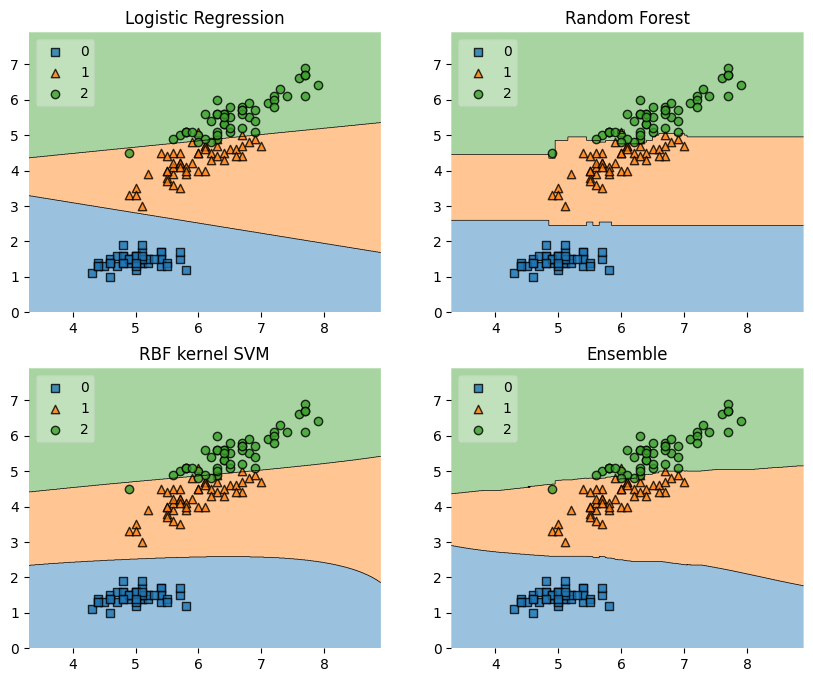

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # 创建多维子图网格的模块
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##主要使用pip install mlxtend安装mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

#### 代码解释

`EnsembleVoteClassifier()`

用于创建集成投票分类器。它可以将多个基分类器的预测结果进行投票，从而得到集成分类器的最终预测结果。

参数包括：
- `clfs`：一个列表，包含要集成的基分类器对象。
- `voting`：设置投票方式，可选的取值为`'hard'`或`'soft'`，分别表示硬投票和软投票。硬投票是指根据少数服从多数的原则选择最多数量的类别作为预测结果，而软投票则是根据分类器预测的概率进行加权计算，并选择概率加权总和最大的类别作为预测结果。
- `weights`：一个可选的列表，用于指定每个基分类器的权重。如果未指定，则默认所有分类器的权重相等。

------

1. `for clf, lab, grd in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'], itertools.product([0, 1], repeat=2)):`：
   - `zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'], itertools.product([0, 1], repeat=2))`将分类器列表、标签列表和网格坐标的笛卡尔积打包在一起，返回一个迭代器。每次迭代返回一个元组`(clf, lab, grd)`，其中`clf`表示分类器对象，`lab`表示标签，`grd`表示网格坐标。
   - `for clf, lab, grd in ...:`遍历迭代器中的每个元组，依次赋值给变量`clf`、`lab`和`grd`。

2. `clf.fit(X, y)`：使用当前分类器`clf`拟合数据集`X`和目标变量`y`，即进行训练。

3. `ax = plt.subplot(gs[grd[0], grd[1]])`：在网格规则对象`gs`上创建一个子图对象，并将其赋值给变量`ax`。通过索引`grd[0]`和`grd[1]`，选择网格规则中的坐标位置。

4. `fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)`：使用`mlxtend.plotting`模块的`plot_decision_regions`函数，在当前子图上绘制决策边界。传入参数包括输入数据集`X`、目标变量`y`、当前分类器`clf`，以及将图例放置的位置`legend=2`。绘制结果会返回一个图形对象，将其赋值给变量`fig`。

5. `plt.title(lab)`：设置当前子图的标题为相应的标签`lab`。

6. 最后一行`plt.show()`：显示整个图形，包含所有子图和决策边界。

通过这段代码，可以实现对每个分类器的训练和决策边界的绘制，并在同一个图形中进行比较和展示。每个分类器都会有一个独立的子图，显示相应的决策边界和标签。最后，通过`plt.show()`将整个图形显示出来。

# 10工业蒸汽赛题多模型融合 stacking方法
## 10.1 基础代码

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# 针对于一个模型进行K折交叉验证的函数
def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1)) # 对话详解
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf","ada","gb","et","lr","lsvc","knn"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict(te_x).reshape(-1,1) # 对话详解
            train[test_index]=pre
            test_pre[i,:]=clf.predict(test_x).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1) # 对话详解
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {'booster': 'gbtree',
                      'eval_metric': 'rmse',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12
                      }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            #z = clf.Dataset(test_x, label=te_y)
            #z=test_x
            params = {
                      'boosting_type': 'gbdt',
                      'objective': 'regression_l2',
                      'metric': 'mse',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12,
                      'silent': True,
                      }
            num_round = 10000
            callbacks=[lightgbm.log_evaluation(period=100), lightgbm.early_stopping(stopping_rounds=100)]
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  callbacks = callbacks
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)



#### 代码详解
这段代码是一个用于堆叠（stacking）回归模型的函数。下面是对每一行代码的逐行解释：

1. `def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):`
   这个函数定义了一个堆叠回归模型的函数，它接受以下参数：
   - `clf`: 使用的基础回归模型
   - `train_x`: 训练集的特征数据
   - `train_y`: 训练集的目标数据
   - `test_x`: 测试集的特征数据
   - `clf_name`: 基础回归模型的名称
   - `kf`: 交叉验证的迭代器
   - `label_split`（可选）: 标签的分割方式

3. `train=np.zeros((train_x.shape[0],1))`
   创建一个形状为`(训练集样本数, 1)`的全零数组，并将其赋值给变量`train`。这个数组用于存储训练集在基础模型上的预测结果。

4. `test=np.zeros((test_x.shape[0],1))`
   创建一个形状为`(测试集样本数, 1)`的全零数组，并将其赋值给变量`test`。这个数组用于存储测试集在基础模型上的预测结果。

5. `test_pre=np.empty((folds,test_x.shape[0],1))`
   创建一个形状为`(folds, 测试集样本数, 1)`的空数组，并将其赋值给变量`test_pre`。这个数组用于存储每次交叉验证中测试集在基础模型上的预测结果。

6. `cv_scores=[]`
   创建一个空列表，并将其赋值给变量`cv_scores`。这个列表用于存储每次交叉验证的均方误差（MSE）。

8. `for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):`   
   遍历交叉验证迭代器`kf`生成的训练集和验证集的索引。每次迭代中，会得到一个训练集的索引和一个验证集的索引。

10. `tr_x=train_x[train_index]`
    根据索引从训练集中获取相应的特征数据，并赋值给变量`tr_x`。

11. `tr_y=train_y[train_index]`
    根据索引从训练集中获取相应的目标数据，并赋值给变量`tr_y`。

12. `te_x=train_x[test_index]`
    根据索引从训练集中获取相应的特征数据，并赋值给变量`te_x`。

13. `te_y=train_y[test_index]`
    根据索引从训练集中获取相应的目标数据，并赋值给变量`te_y`。

15-62. 基于不同的基础回归模型进行训练和预测，并计算均方误差（MSE）：
   - 如果`clf_name`在`["rf","ada","gb","et","lr","lsvc","knn"]`中，使用`clf.fit()`方法进行训练，然后使用`clf.predict()`方法进行预测，并将预测结果存储在相应的变量中。
   - 如果`clf_name`是`"xgb"`，则使用XGBoost库进行训练和预测。具体的参数设置和训练过程与XGBoost相关。
   - 如果`clf_name`是`"lgb"`，则使用LightGBM库进行训练和预测。具体的参数设置和训练过程与LightGBM相关。

64. `raise IOError("Please add new clf.")`
    如果`clf_name`不属于任何已定义的模型名称，则抛出一个错误。

66. `print("%s now score is:"%clf_name,cv_scores)`
    打印当前基础回归模型的均方误差。

68. `test[:]=test_pre.mean(axis=0)`
    计算所有交叉验证模型的预测结果的平均值，并将结果赋值给`test`变量。

70-71. 分别打印基础回归模型的均方误差列表和均值。

73. `return train.reshape(-1,1),test.reshape(-1,1)`
    返回训练集和测试集的预测结果，其中预测结果的形状为`(样本数, 1)`。
    
    
---------
    
    
15-62.代码是一个用于训练和评估XGBoost或LightGBM模型的逻辑。我将逐行解释代码的功能：

1. `train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)`: 使用XGBoost库的`DMatrix`方法创建训练数据矩阵，其中`tr_x`是特征数据，`tr_y`是目标数据，`missing=-1`表示缺失值的表示方式。

2. `test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)`: 使用XGBoost库的`DMatrix`方法创建测试数据矩阵，其中`te_x`是特征数据，`te_y`是目标数据，`missing=-1`表示缺失值的表示方式。

3. `z = clf.DMatrix(test_x, label=te_y, missing=-1)`: 使用XGBoost库的`DMatrix`方法创建用于预测的数据矩阵，其中`test_x`是特征数据，`te_y`是目标数据，`missing=-1`表示缺失值的表示方式。

4. `params = {...}`: 设置XGBoost模型的参数，包括树的深度、学习率、正则化等。

5. `num_round = 10000`: 设置迭代轮数。

6. `early_stopping_rounds = 100`: 设置在验证集上早停的轮数。

7. `watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]`: 创建监控列表用于跟踪训练和测试集上的性能。

8. `model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,early_stopping_rounds=early_stopping_rounds)`: 使用XGBoost库的`train`方法训练模型，其中`params`是模型参数，`train_matrix`是训练数据矩阵，`num_boost_round`是迭代轮数，`evals`是监控列表，`early_stopping_rounds`是早停的轮数。

9. `pre = model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)`: 对测试数据进行预测，并将结果重塑为一列。

10. `train[test_index] = pre`: 将对测试集的预测结果保存在训练集的相应位置。

11. `test_pre[i, :] = model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)`: 对预测数据进行预测，并将结果保存在`test_pre`数组的第i行。

12. `cv_scores.append(mean_squared_error(te_y, pre))`: 将平均均方误差（MSE）添加到交叉验证分数列表中。

13. `train_matrix = clf.Dataset(tr_x, label=tr_y)`: 使用LightGBM库的`Dataset`方法创建训练数据集。

14. `test_matrix = clf.Dataset(te_x, label=te_y)`: 使用LightGBM库的`Dataset`方法创建测试数据集。

15. `params = {...}`: 设置LightGBM模型的参数，包括树的深度、学习率、正则化等。

16. `model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,early_stopping_rounds=early_stopping_rounds)`: 使用LightGBM库的`train`方法训练模型，其中`params`是模型参数，`train_matrix`是训练数据集，`num_round`是迭代轮数，`valid_sets`是用于验证的数据集，`early_stopping_rounds`是早停的轮数。

17. `pre = model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)`: 对测试数据进行预测，并将结果重塑为一列。

18. `train[test_index] = pre`: 将对测试集的预测结果保存在训练集的相应位置。

19. `test_pre[i, :] = model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)`: 对预测数据进行预测，并将结果保存在`test_pre`数组的第i行。

20. `cv_scores.append(mean_squared_error(te_y, pre))`: 将平均均方误差（MSE）添加到交叉验证分数列表中。

#### 代码整体思路

1. 创建一些空数组和变量，包括`train`（训练集预测结果）、`test`（测试集预测结果）、`test_pre`（测试集在各折交叉验证下的预测结果）和`cv_scores`（交叉验证得分列表）。

2. 对于交叉验证的每一折，进行以下操作：
   - 根据当前折的索引，获取训练集的索引和测试集的索引。
   - 根据索引从训练集和标签中抽取对应的样本和标签。
   - 如果分类器名称在['rf'、'ada'、'gb'、'et'、'lr'、'lsvc'、'knn']中，则使用分类器训练模型，进行预测，并将预测结果存储在相应的数组中。
   - 如果分类器名称为'xgb'，则使用XGBoost训练模型，进行预测，并将预测结果存储在相应的数组中。
   - 如果分类器名称为'lgb'，则使用LightGBM训练模型，进行预测，并将预测结果存储在相应的数组中。
   - 计算当前折的均方误差得分，并将其添加到cv_scores列表中。

3. 计算所有折的平均预测结果，并将其存储在test数组中。

4. 打印分类器名称、交叉验证得分列表和平均得分。

5. 将train和test数组重新整形为列向量，并返回它们作为函数的输出。

## 10.2 模型融合stacking基学习器

In [ ]:

def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf_reg"

def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada_reg"

def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb_reg"

def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et_reg"

def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg=LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr_reg"

def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb_reg"

def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return lgb_train, lgb_test,"lgb_reg"

#### 代码解释

1. `rf_reg` 函数：
   - 首先，使用随机森林回归器 `RandomForestRegressor` 创建一个随机森林模型。设置了一些参数，如树的数量(`n_estimators`)、最大深度(`max_depth`)、并行运算的CPU核数(`n_jobs`)等。
   - 接下来，调用 `stacking_reg` 函数，将创建的随机森林模型作为基学习器进行堆叠集成学习。该函数的作用是对训练数据 `x_train` 进行 K 折交叉验证，并返回基学习器在训练集和验证集上的预测结果。
   - 最后，返回训练集的预测结果 `rf_train`、验证集的预测结果 `rf_test` 和标识符字符串 `"rf_reg"`。

2. `ada_reg` 函数：
   - 首先，使用 AdaBoost 回归器 `AdaBoostRegressor` 创建一个 AdaBoost 模型。设置了一些参数，如基学习器的数量(`n_estimators`)、学习率(`learning_rate`)等。
   - 接下来，调用 `stacking_reg` 函数，将创建的 AdaBoost 模型作为基学习器进行堆叠集成学习。该函数的作用和上述相同，对训练数据 `x_train` 进行 K 折交叉验证，并返回基学习器在训练集和验证集上的预测结果。
   - 最后，返回训练集的预测结果 `ada_train`、验证集的预测结果 `ada_test` 和标识符字符串 `"ada_reg"`。
   
   
  ······

代码的目的是创建不同的基学习器，并将其作为基础模型进行堆叠集成学习。通过堆叠集成学习，可以利用各个基学习器的优势，提高整体模型的预测性能。最后，返回训练集和验证集上的预测结果以及标识符字符串。

## 10.3 定义模型融合stacking预测函数

In [ ]:
def stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True):
    # 第一层-结果为train test
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list=[]
        test_data_list=[]
        for clf in clf_list:
            train_data,test_data,clf_name=clf(x_train, y_train, x_valid, kf, label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)
     
    # 是否选择原始特征拼接
    if if_concat_origin:
        train = np.concatenate([x_train, train], axis=1)
        test = np.concatenate([x_valid, test], axis=1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    # 第二层
    if clf_fin in ["rf","ada","gb","et","lr","lsvc","knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs=-1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1,1)
        return pred
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        test_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        params = {'booster': 'gbtree',
                  'eval_metric': 'rmse',
                  'gamma': 1,
                  'min_child_weight': 1.5,
                  'max_depth': 5,
                  'lambda': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'eta': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12
                  }
        num_round = 10000
        #early_stopping_rounds = 100
        callbacks=[lightgbm.log_evaluation(period=100), lightgbm.early_stopping(stopping_rounds=100)]
        watchlist = [(train_matrix, 'train'),
                     (test_matrix, 'eval')
                     ]
        model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                          #early_stopping_rounds=early_stopping_rounds
                          callbacks=callbacks
                          )
        pre = model.predict(test,ntree_limit=model.best_ntree_limit).reshape(-1,1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label=y_train)
        test_matrix = clf.Dataset(train, label=y_train)
        params = {
                  'boosting_type': 'gbdt',
                  'objective': 'regression_l2',
                  'metric': 'mse',
                  'min_child_weight': 1.5,
                  'num_leaves': 2**5,
                  'lambda_l2': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'learning_rate': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12,
                  'silent': True,
                  }
        num_round = 10000
        #early_stopping_rounds = 100
        callbacks=[lightgbm.log_evaluation(period=100), lightgbm.early_stopping(stopping_rounds=100)]
        model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                          #early_stopping_rounds=early_stopping_rounds
                          callbacks=callbacks
                          )
        print('pred')
        pre = model.predict(test,num_iteration=model.best_iteration).reshape(-1,1)
        print(pre)
        return pre

## 10.4 使用lr_reg和lgb_reg进行融合预测

加载数据

In [ ]:
# load_dataset
with open("./data/zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./data/zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")
    

K折交叉验证

In [ ]:
# K折交叉验证
from sklearn.model_selection import StratifiedKFold, KFold

folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

训练集和测试集数据

In [ ]:
# 训练集
x_train = data_train[data_test.columns].values
y_train = data_train['target'].values
# 测试集
x_valid = data_test[data_test.columns].values

使用lr_reg和lgb_reg进行融合预测

In [ ]:
clf_list = [lr_reg, lgb_reg]

##很容易过拟合
pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True)

lr now score is: [0.11573216950871251]
lr now score is: [0.11573216950871251, 0.0941748642661893]
lr now score is: [0.11573216950871251, 0.0941748642661893, 0.10805046561851066]
lr now score is: [0.11573216950871251, 0.0941748642661893, 0.10805046561851066, 0.12420887065601559]
lr now score is: [0.11573216950871251, 0.0941748642661893, 0.10805046561851066, 0.12420887065601559, 0.11940113841914018]
lr_score_list: [0.11573216950871251, 0.0941748642661893, 0.10805046561851066, 0.12420887065601559, 0.11940113841914018]
lr_score_mean: 0.11231350169371365
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_col_

[200]	valid_0's l2: 0.0476533
[300]	valid_0's l2: 0.0327543
[400]	valid_0's l2: 0.0234317
[500]	valid_0's l2: 0.0171615
[600]	valid_0's l2: 0.01265
[700]	valid_0's l2: 0.00937673
[800]	valid_0's l2: 0.00701643
[900]	valid_0's l2: 0.0052999
[1000]	valid_0's l2: 0.00401402
[1100]	valid_0's l2: 0.00304895
[1200]	valid_0's l2: 0.00233589
[1300]	valid_0's l2: 0.0017952
[1400]	valid_0's l2: 0.0013869
[1500]	valid_0's l2: 0.00107115
[1600]	valid_0's l2: 0.000834574
[1700]	valid_0's l2: 0.000648769
[1800]	valid_0's l2: 0.000503304
[1900]	valid_0's l2: 0.000391588
[2000]	valid_0's l2: 0.000307804
[2100]	valid_0's l2: 0.000239007
[2200]	valid_0's l2: 0.000187782
[2300]	valid_0's l2: 0.00014864
[2400]	valid_0's l2: 0.000116869
[2500]	valid_0's l2: 9.17773e-05
[2600]	valid_0's l2: 7.2771e-05
[2700]	valid_0's l2: 5.79037e-05
[2800]	valid_0's l2: 4.59578e-05
[2900]	valid_0's l2: 3.65579e-05
[3000]	valid_0's l2: 2.9115e-05
[3100]	valid_0's l2: 2.3409e-05
[3200]	valid_0's l2: 1.87523e-05
[3300]	valid_

预测结果

In [ ]:
pred

array([[ 0.41700189],
       [ 0.37101204],
       [ 0.1479981 ],
       ...,
       [-2.48570445],
       [-2.4264629 ],
       [-2.48367665]])

In [ ]:
# 将pred转换为一维数组
pred_flat = pred.flatten()

# 保存为文本文件
np.savetxt('pred.txt', pred_flat)